# Import

In [1]:
import os
import numpy as np

from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
import lightkurve as lk
from astroquery.simbad import Simbad
import pandas as pd 
from numpy import genfromtxt
from sklearn.preprocessing import normalize
from labellines import labelLine, labelLines


# #tf
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error



## Check GPU

In [2]:
devices = tf.config.list_physical_devices()
print(devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import Data

In [3]:
pd.read_csv('/Users/michaelsong/Documents/GitHub/starzam/Data_v4/0.csv',delimiter=',').to_numpy().shape

(122, 241)

In [4]:
all_data = np.empty((1,240))
for dataset in ['Data_v4']:
  new_data = np.empty((1,241))
  for i in range(1610*2):
    try:
      new_data = np.concatenate((new_data,pd.read_csv('/Users/michaelsong/Documents/GitHub/starzam/'+dataset+'/'+str(i)+'.csv',delimiter=',').to_numpy()), axis=0)
    except:
      continue
  new_data = new_data[1:].T[1:].T
  print(new_data.shape)
  all_data = np.concatenate((all_data,new_data),axis=0)
all_data = all_data[1:]
print(all_data.shape)
# pd.read_csv('/content/drive/MyDrive/Research - Yihong Song and Rohit Prasanna/Yihong/Data_v2/0.csv',delimiter=',').to_numpy

(214499, 240)
(214499, 240)


In [5]:
print(all_data)
print(all_data.T[1])

[[7.57137000e+05 4.75100000e+03 2.38300000e+00 ... 2.84220046e-01
  1.98787545e-01 3.52143589e-01]
 [7.57137000e+05 4.75100000e+03 2.38300000e+00 ... 9.00410425e-02
  2.38116041e-01 1.33820551e-01]
 [7.57137000e+05 4.75100000e+03 2.38300000e+00 ... 6.99888643e-02
  1.28790969e-01 2.76750793e-01]
 ...
 [1.29345740e+07 4.83400000e+03 2.38700000e+00 ... 2.39368800e-01
  1.34656354e-01 3.30117909e-01]
 [1.29345740e+07 4.83400000e+03 2.38700000e+00 ... 5.32880594e-01
  1.53275869e-01 1.18398710e+00]
 [1.29345740e+07 4.83400000e+03 2.38700000e+00 ... 2.38655505e-01
  4.39093700e-01 9.84966052e-01]]
[4751. 4751. 4751. ... 4834. 4834. 4834.]


In [6]:
def isolate_observations(data):
    kic = 0
    res = np.empty((1,474))
    for i in range(len(data)):
        if(data[i][0]!=kic):
            kic = data[i][0]
            res = np.vstack((res,data[i]))
    return res

# iso_data = isolate_observations(all_data).T[:10].T
# print(iso_data)

In [80]:
def extract_xy(all_data):
    all_x = all_data.T[4:241].T
    all_y = all_data.T[1:4].T
    print(all_x.shape,all_y.shape)
    teff_y = all_y.T[0].T
    print(teff_y.shape)
    print(teff_y)
    print(all_x[0])
    return all_x,teff_y

all_x,teff_y = extract_xy(all_data)

(214499, 236) (214499, 3)
(214499,)
[4751. 4751. 4751. ... 4834. 4834. 4834.]
[ 0.         13.16467881 11.85662574  5.37137053  2.34753016  7.56242166
  7.09166395  8.9345866   4.47222976  5.44573758  7.99705157  6.5553589
  7.43230342  2.14978082  6.70502292  2.11453161  1.47941903  3.4679212
  0.95694623  6.41945024 13.71684545  2.6618294   6.7777871   4.03523607
  1.65132679  1.22634052  2.47702523  1.62667739  2.94700681  2.16647403
  0.86192238  1.94095918  1.36412959  1.50011758  1.52687553  0.3987771
  0.26511563  1.70271956  2.16544294  1.24192005  0.74680304  1.26339405
  2.43964765  0.62723454  1.35998087  0.3313366   0.39359298  0.8410012
  0.59152181  0.47106868  1.50347768  1.05735322  0.37600592  1.01079496
  0.06908752  1.03337513  0.57106625  0.72521993  0.70155079  0.43960006
  1.06916899  1.62702797  0.75722071  0.81743033  0.08991218  0.78076904
  0.58342839  0.82547409  1.41460742  0.44502772  0.51703072  0.16467888
  0.85940931  0.28964864  0.38246988  0.20737913  

In [81]:
def normalize_with_moments(X_train, axes=0, epsilon=1e-8,keep_dims=True):
    x = tf.convert_to_tensor(X_train)
    mean, variance = tf.nn.moments(x, axes=axes)
    x_normed = (x - mean) / tf.sqrt(variance + epsilon) # epsilon to avoid dividing by zero
    return x_normed

def normalize_x(x):
    x = x.T
    for i in range(len(x)):
        x[i] = x[i] / np.linalg.norm(x[i])
    return x.T

In [82]:
# teff_y = normalize_with_moments(teff_y).numpy()
# all_x = normalize_x(all_x)
# print(teff_y)
# print(all_x)

In [83]:
print(all_x[1])

[ 1.          8.43454255  3.81606884  5.60029841  4.00062612  1.87763442
  6.60502431  1.75453517  2.03889624  2.15967502  6.61839709 10.96603738
  1.00941128 11.83732916  6.832062    2.11275395  0.68517313  2.80103935
  3.12226637  2.10477594  6.60518561  0.61505648  2.00240753  3.97648499
  1.3740333   1.3024308   2.02690753  1.48491184  1.63691857  1.22361546
  2.55480434  1.85227138  0.76009708  0.77010233  0.35528595  1.09636679
  0.89292322  1.34251061  0.63681166  0.43798736  1.08026908  0.28756933
  0.23743421  0.18253782  0.52691456  0.34023662  0.32434848  0.73180473
  0.15601266  0.71085421  0.67786938  0.25223334  0.57520825  0.52608914
  0.17351905  0.61305125  0.5747885   0.35867008  0.50785905  0.28822274
  0.18542083  0.72036011  0.74996212  0.78635087  0.37852229  0.35192467
  0.29241703  0.1940635   0.62021354  0.59715896  0.32950041  0.48906543
  0.57471503  0.23230492  0.60162748  0.24766141  0.32702928  0.24256991
  0.30468094  0.40705864  0.32715655  0.47648729  0

# Machine Learning

In [84]:
train_x,test_x,train_y,test_y=train_test_split(all_x, teff_y, test_size=0.20, random_state=42)
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)
train_x = np.asarray(train_x).astype('float32')
test_x = np.asarray(test_x).astype('float32')
train_y = np.asarray(train_y).astype('float32')
test_y = np.asarray(test_y).astype('float32')
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)

# # Convolutional
# train_x = train_x[..., None]
# test_x = test_x[..., None]
# train_y = train_y[..., None]
# test_y = test_y[..., None]
# print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)

(171599, 236) (42900, 236) (171599,) (42900,)
(171599, 236) (42900, 236) (171599,) (42900,)


In [85]:
tf.test.gpu_device_name() # No GPU Sad :v
# tf.config.optimizer.set_jit(True)
keras.backend.clear_session()
# model = models.Sequential()

# model.add(layers.Conv1D(1024, 1, activation='relu',batch_input_shape=train_x.shape))
# model.add(layers.Dense(128))
# model.add(layers.Conv1D(32, 1, activation='relu'))
# model.add(layers.Dense(1,activation="sigmoid"))

# model.summary()
model = models.Sequential()
#model.add(layers.Conv1D(filters=16, kernel_size=1, activation='relu', batch_input_shape=(train_x.shape)))

#model.add(layers.Embedding(input_dim=64, output_dim=16))
#model.add(layers.LSTM(128,dr
# opout=0.2,recurrent_dropout=0.2,input_dim=(train_x.shape[2])))
#model.add(layers.Conv1D(1024,1,activation='relu',input_shape=(train_x.shape)))
#model.add(layers.Conv1D(256,1,activation='relu'))
model.add(layers.Dense(1, activation="relu", input_shape=((236,))))
# model.add(layers.Conv1D(filters=128, kernel_size=4, activation='relu', input_shape=(236,1)))
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Conv1D(filters=32, kernel_size=4, activation='relu'))
# model.add(layers.MaxPooling1D(pool_size=2))
# model.add(layers.Dense(1024, activation="relu"))
# model.add(layers.Dense(512, activation="relu"))
# model.add(layers.Dense(256, activation="relu"))
# model.add(layers.Dense(128, activation="relu"))
# model.add(layers.Dense(64, activation="relu"))
# model.add(layers.Dense(32, activation="relu"))
# model.add(layers.Dense(4, activation="relu"))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 237       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 239
Trainable params: 239
Non-trainable params: 0
_________________________________________________________________


2022-01-31 02:22:18.683941: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-31 02:22:18.683970: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [86]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=5, min_lr=0.001)
monitor = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, 
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)

# def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('loss') <= 15000):
#         print("\n\n\nReached 0.05 loss value so cancelling training!\n\n\n")
#         model.stop_training = True


# trainingStopCallback = on_epoch_end()


In [87]:
history = model.fit(train_x, train_y, epochs=1000,validation_data=(test_x, test_y),callbacks=[monitor], verbose=2)
# history = model.fit(train_x, train_y, epochs=150,validation_data=(test_x, test_y), verbose=2)

Epoch 1/1000


2022-01-31 02:22:26.111037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-31 02:22:43.268550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5363/5363 - 20s - loss: 11012251.0000 - accuracy: 0.0000e+00 - val_loss: 5270754.5000 - val_accuracy: 0.0000e+00
Epoch 2/1000
5363/5363 - 21s - loss: 5197186.0000 - accuracy: 0.0000e+00 - val_loss: 4762386.5000 - val_accuracy: 0.0000e+00
Epoch 3/1000
5363/5363 - 22s - loss: 4713002.0000 - accuracy: 0.0000e+00 - val_loss: 4303849.0000 - val_accuracy: 0.0000e+00
Epoch 4/1000
5363/5363 - 21s - loss: 4276134.5000 - accuracy: 0.0000e+00 - val_loss: 3904082.0000 - val_accuracy: 0.0000e+00
Epoch 5/1000
5363/5363 - 22s - loss: 3891418.2500 - accuracy: 0.0000e+00 - val_loss: 3559741.5000 - val_accuracy: 0.0000e+00
Epoch 6/1000
5363/5363 - 22s - loss: 3567069.5000 - accuracy: 0.0000e+00 - val_loss: 3258684.7500 - val_accuracy: 0.0000e+00
Epoch 7/1000
5363/5363 - 19s - loss: 3267712.7500 - accuracy: 0.0000e+00 - val_loss: 2998922.7500 - val_accuracy: 0.0000e+00
Epoch 8/1000
5363/5363 - 21s - loss: 3031543.0000 - accuracy: 0.0000e+00 - val_loss: 2803852.7500 - val_accuracy: 0.0000e+00
Epoch 9/1000

In [88]:
model.save('/Users/michaelsong/Documents/GitHub/starzam/Models/m5.13')

INFO:tensorflow:Assets written to: /Users/michaelsong/Documents/GitHub/starzam/Models/m5.13/assets


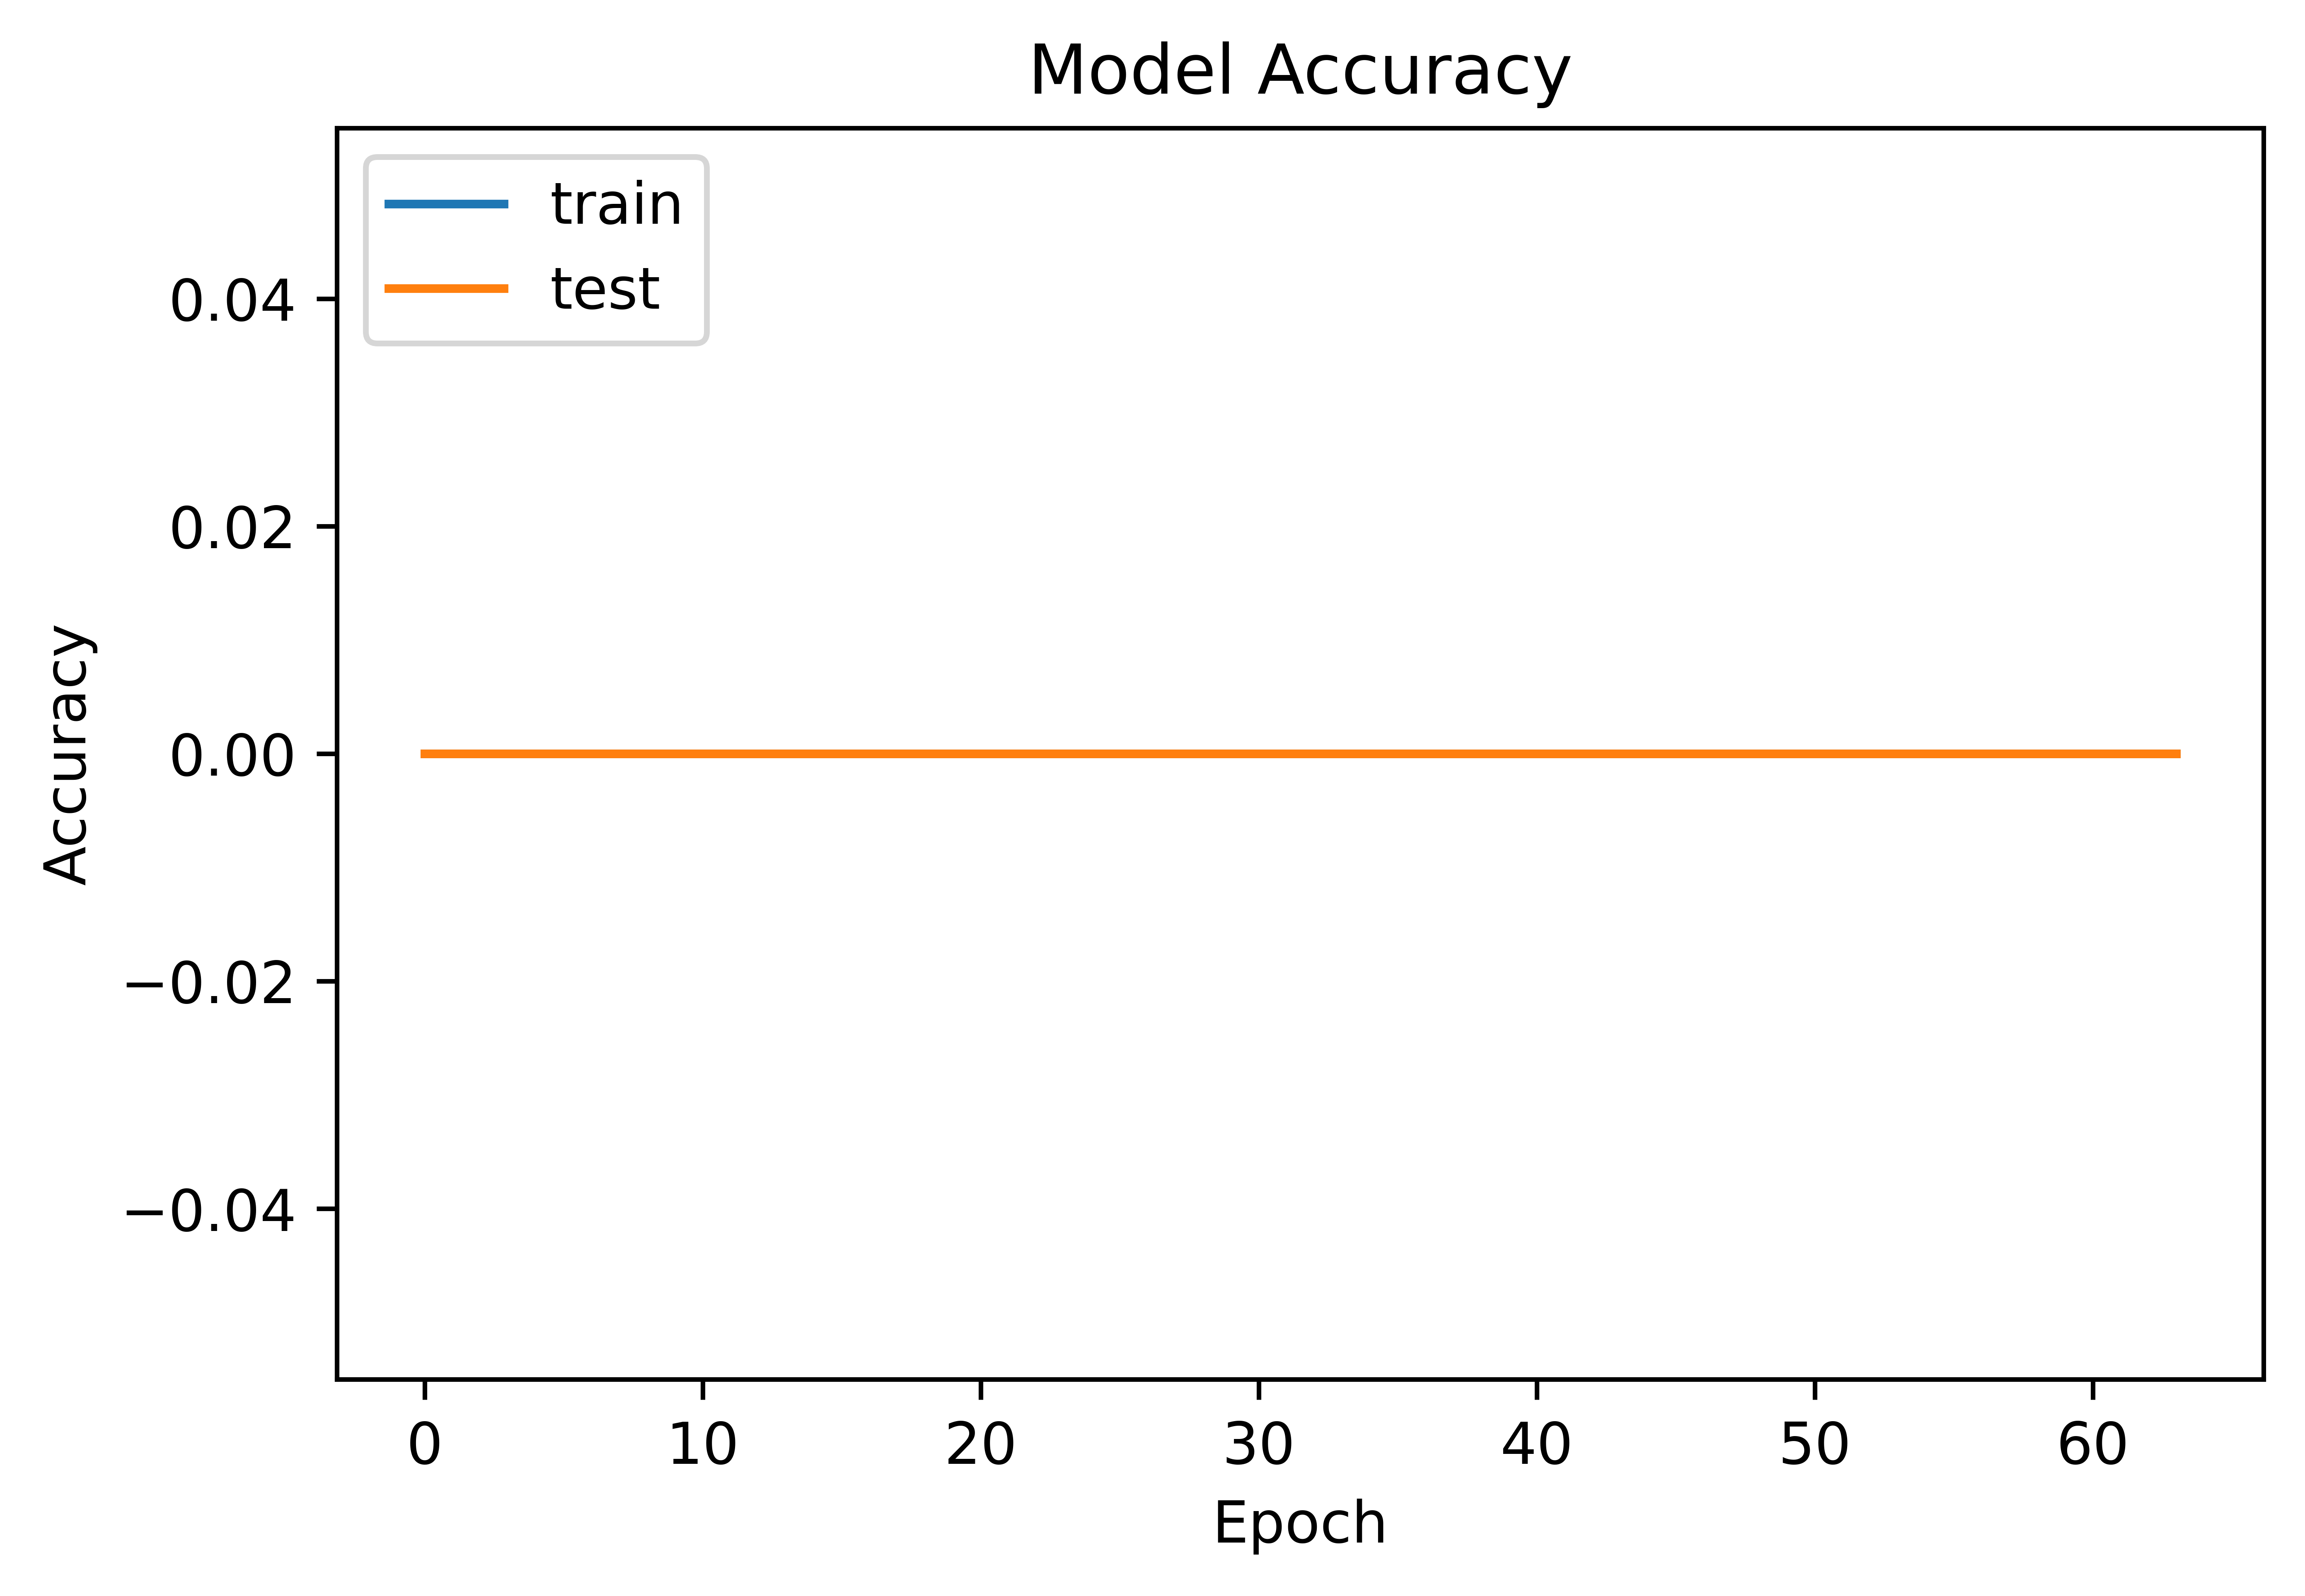

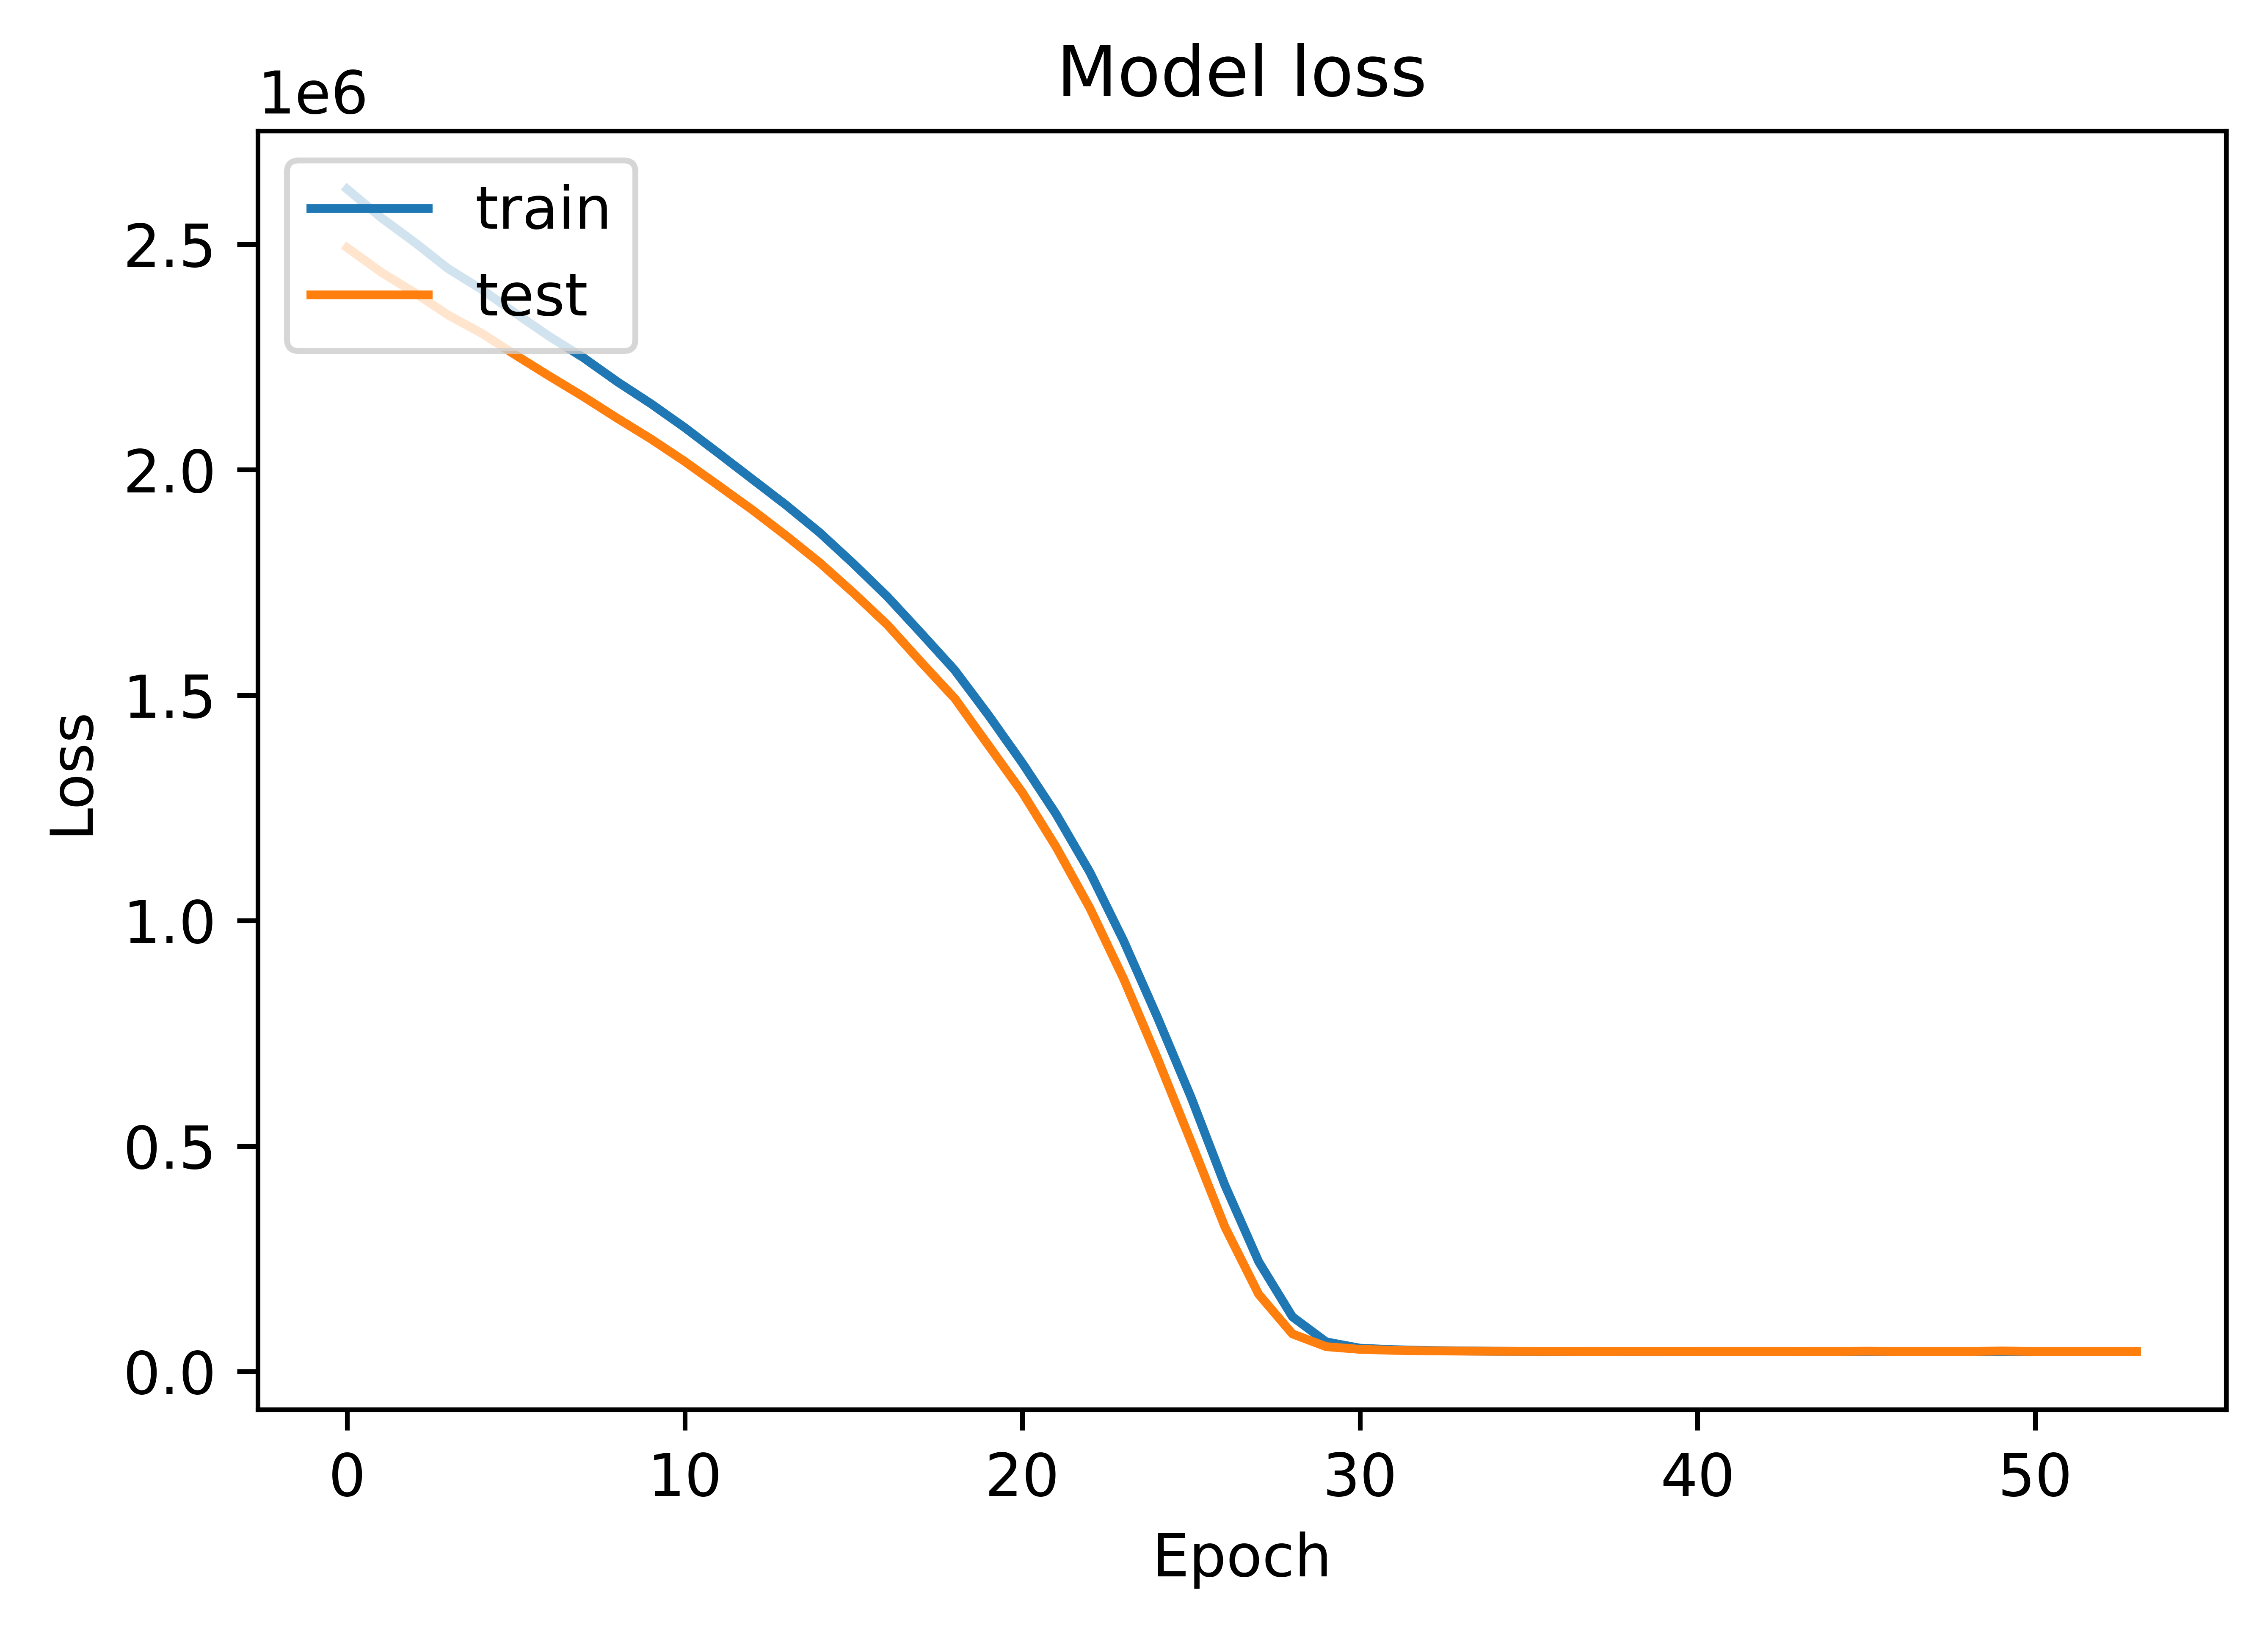

In [89]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('/Users/michaelsong/Documents/GitHub/starzam/Results/5.13_training.png')
plt.show()

In [90]:
# model = tf.keras.models.load_model('/Users/michaelsong/Documents/GitHub/starzam/Models/m5.7')

# # Check its architecture
# model.summary()

In [91]:
weights = model.get_weights()
print(weights[1])
print(weights[2])
print(weights[3])
print(np.where(weights[0] > 0))
print(weights[0][26:150])

[184.44398]
[[25.841248]]
[181.46017]
(array([ 12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  32,  34,  35,  36,  51,  53,  55,  57,  58,
        59,  60,  61,  62,  63,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  76,  79,  81,  84,  85,  86,  87,  89,  90,  92,  93,
        95,  96,  97,  98,  99, 100, 101, 102, 105, 107, 110, 112, 113,
       115, 117, 118, 119, 120, 122, 123, 124, 126, 127, 128, 129, 130,
       132, 134, 136, 137, 138, 139, 141, 142, 143, 146, 147, 148, 149,
       150, 152, 153, 154, 156, 157, 158, 159, 161, 162, 163, 164, 165,
       166, 167, 170, 171, 172, 174, 175, 176, 177, 178, 179, 181, 182,
       183, 184, 185, 187, 188, 191, 193, 196, 198, 204, 205, 206, 209,
       229]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0

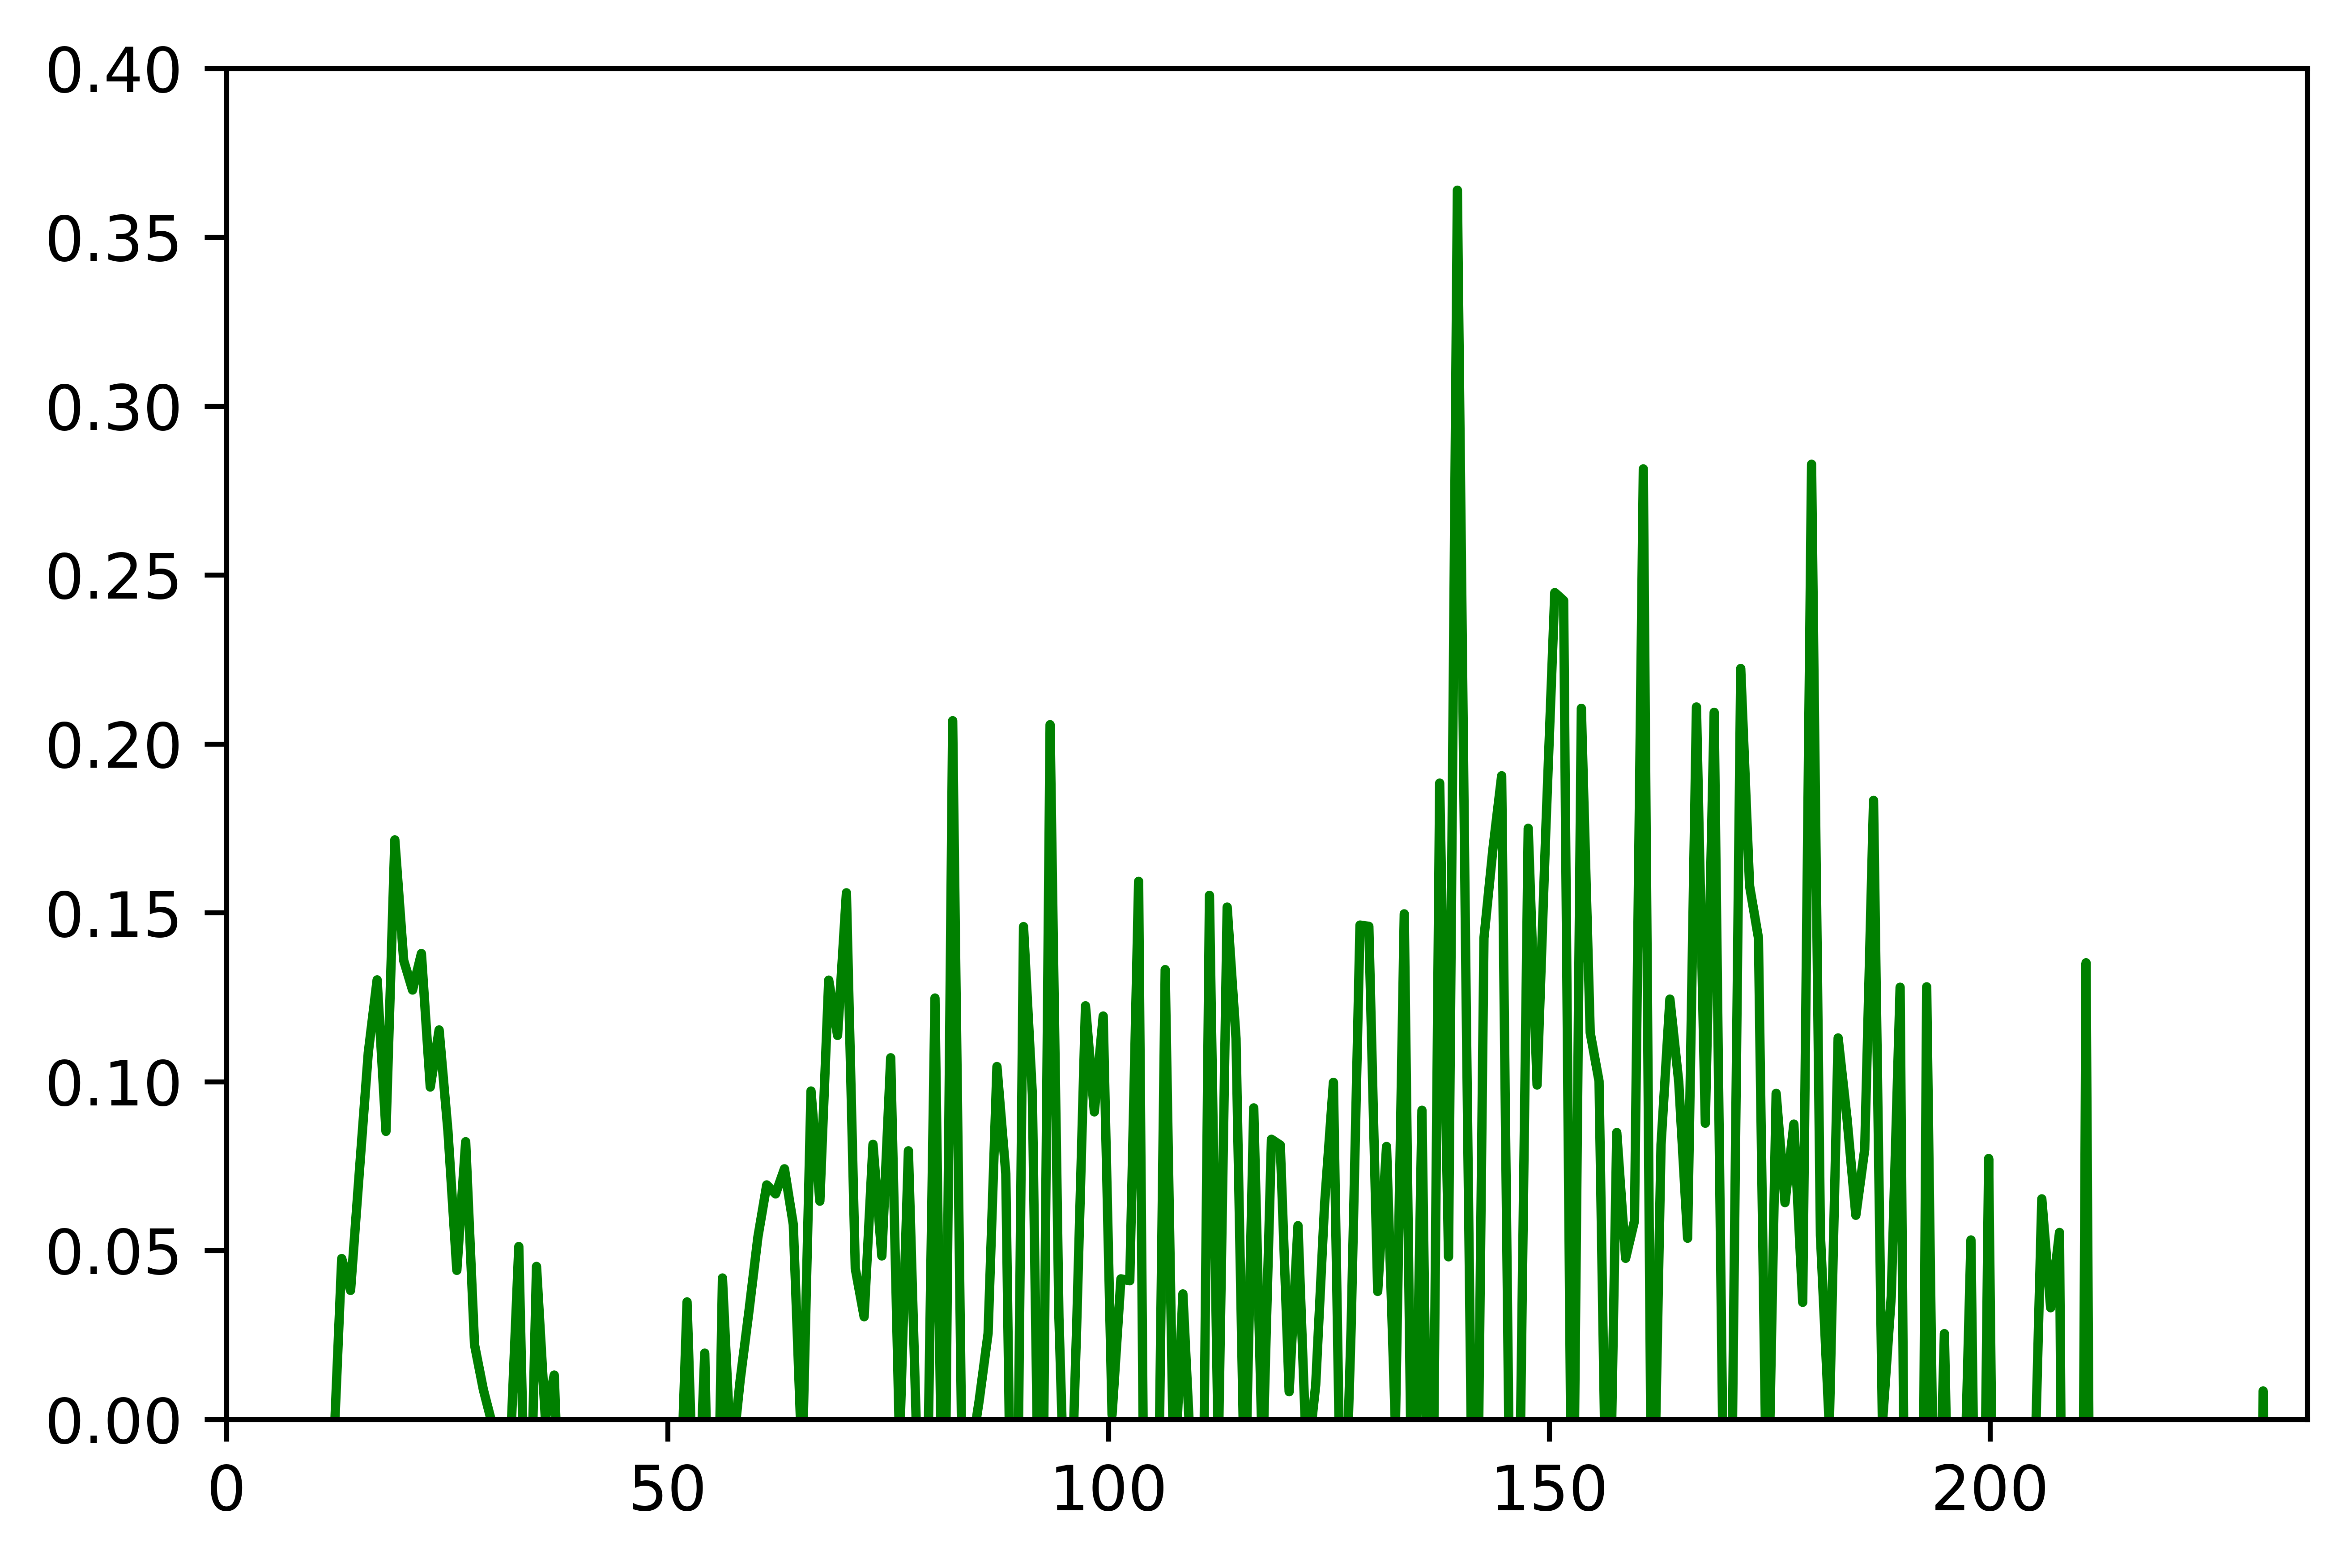

In [96]:
plt.rcParams['figure.dpi'] = 1000
# plt.figure(figsize = (6.4,4.8))
# plt.scatter(train_y[:500],pred_train_y[:500], c='red', alpha=0.5,s=0.5)
# plt.scatter(test_y[:500],pred_test_y[:500], c='blue', alpha=0.5,s=0.5)
# plt.hist2d(train_y,pred_train_y,bins=[100,100],cmin=20)
# plt.hist2d(test_y,pred_test_y,bins=[100,100],cmin=20,cmap=plt.cm.BuPu)


# plt.scatter(rand_y,pred_rand_y, c='orange', alpha=0.5,s=0.1)

# bot = 4000
# top = 6000
# bot = 2
# top = 4

linex = np.linspace(1,237,236)
# liney = linex
# lineytop = linex*1.06
# lineybot = linex*0.94
# lineytop2 = linex*1.05
# lineybot2 = linex*0.95
# # Create the plot
plt.plot(linex, weights[0].flatten(),c="green",label="±0")
# # plt.plot(linex, lineytop,c="red",label="+6%")
# # plt.plot(linex, lineybot,c="red",label="-6%")
# plt.plot(linex, lineytop2,c="orange",label="+200")
# plt.plot(linex, lineybot2,c="orange",label="-200")
# labelLines(plt.gca().get_lines(), zorder=2.5)


plt.xlim(0,236)
plt.ylim(0,0.4)
# plt.gca().set_aspect(2, adjustable='box')
# plt.title('Sampled Prediction Data, 1000 Points')
# plt.ylabel('Predicted Effective Temperature (°K)')
# plt.xlabel('Measured Effective Temperature (°K)')
# lgnd = plt.legend(['train', 'test'], loc='upper left')
# lgnd.legendHandles[0]._sizes = [20]
# lgnd.legendHandles[1]._sizes = [20]
plt.savefig('/Users/michaelsong/Documents/GitHub/starzam/Results/w2.png')
plt.show()


In [20]:
# plot_model(model,to_file='/Users/michaelsong/Documents/GitHub/starzam/Results/5.7_model',show_shapes=True)
# plot_model(
#     model,
#     to_file='/Users/michaelsong/Documents/GitHub/starzam/Results/5.7_model',
#     show_shapes=False,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
# )

In [21]:
rand_data = np.empty((1,241))
for i in range(1610):
  try:
    rand_data = np.concatenate((rand_data,pd.read_csv('/Users/michaelsong/Documents/GitHub/starzam/Data_v5/'+str(i)+'.csv',delimiter=',').to_numpy()), axis=0)
  except:
    continue
rand_data = rand_data[1:].T[1:].T
print(rand_data.shape)
# pd.read_csv('/content/drive/MyDrive/Research - Yihong Song and Rohit Prasanna/Yihong/Data_v2/0.csv',delimiter=',').to_numpy

(215222, 240)


In [97]:
rand_x,rand_y = extract_xy(rand_data)
# rand_x = train_x[214499:]
# rand_y = train_y[214499:]
# train_x = train_x[:214499]
# train_y = train_y[:214499]

(215222, 236) (215222, 3)
(215222,)
[4751. 4751. 4751. ... 4834. 4834. 4834.]
[ 0.         14.90008455 15.50298007  5.21597451  0.90830632  6.20644851
  7.57179809 11.6459395   4.23234164  5.94067695  6.52288898  8.24150251
  8.24082509  3.0395033   6.79973021  4.53366015  0.3684131   3.1691568
  1.80376791  5.53454395 14.8961291   2.74725918  7.71266579  4.99388222
  2.06427727  1.78502294  2.54900389  1.96493493  2.57559828  1.92052474
  0.80277816  1.99947775  1.35893309  1.67625249  1.17480514  0.25672505
  0.31081051  1.21989282  1.70213929  1.20731647  0.93159443  0.81903248
  2.22338649  0.69065388  1.11967885  0.22592404  0.31651415  0.71181726
  0.17388933  0.66229278  1.18461127  1.10461002  0.83177554  1.0551641
  0.48302564  1.57553744  0.17964806  0.794371    0.86703197  0.45893159
  1.34795274  1.30622146  0.83207013  0.63664459  0.30800708  0.87276054
  0.45499416  0.83302011  1.15396698  0.35490575  0.63358948  0.33101004
  0.76273555  0.2994764   0.32217782  0.10424394

In [98]:
pred_test_y = model.predict(test_x).reshape(-1)
pred_train_y = model.predict(train_x).reshape(-1)
pred_rand_y = model.predict(rand_x).reshape(-1)
print(pred_test_y.shape,pred_train_y.shape)
print(pred_train_y)
print(train_y)

2022-01-31 02:49:50.282912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(42900,) (171599,)
[4874.87   4974.314  4944.6304 ... 4898.834  4960.451  4989.3364]
[5116. 5013. 4996. ... 5145. 4924. 4820.]


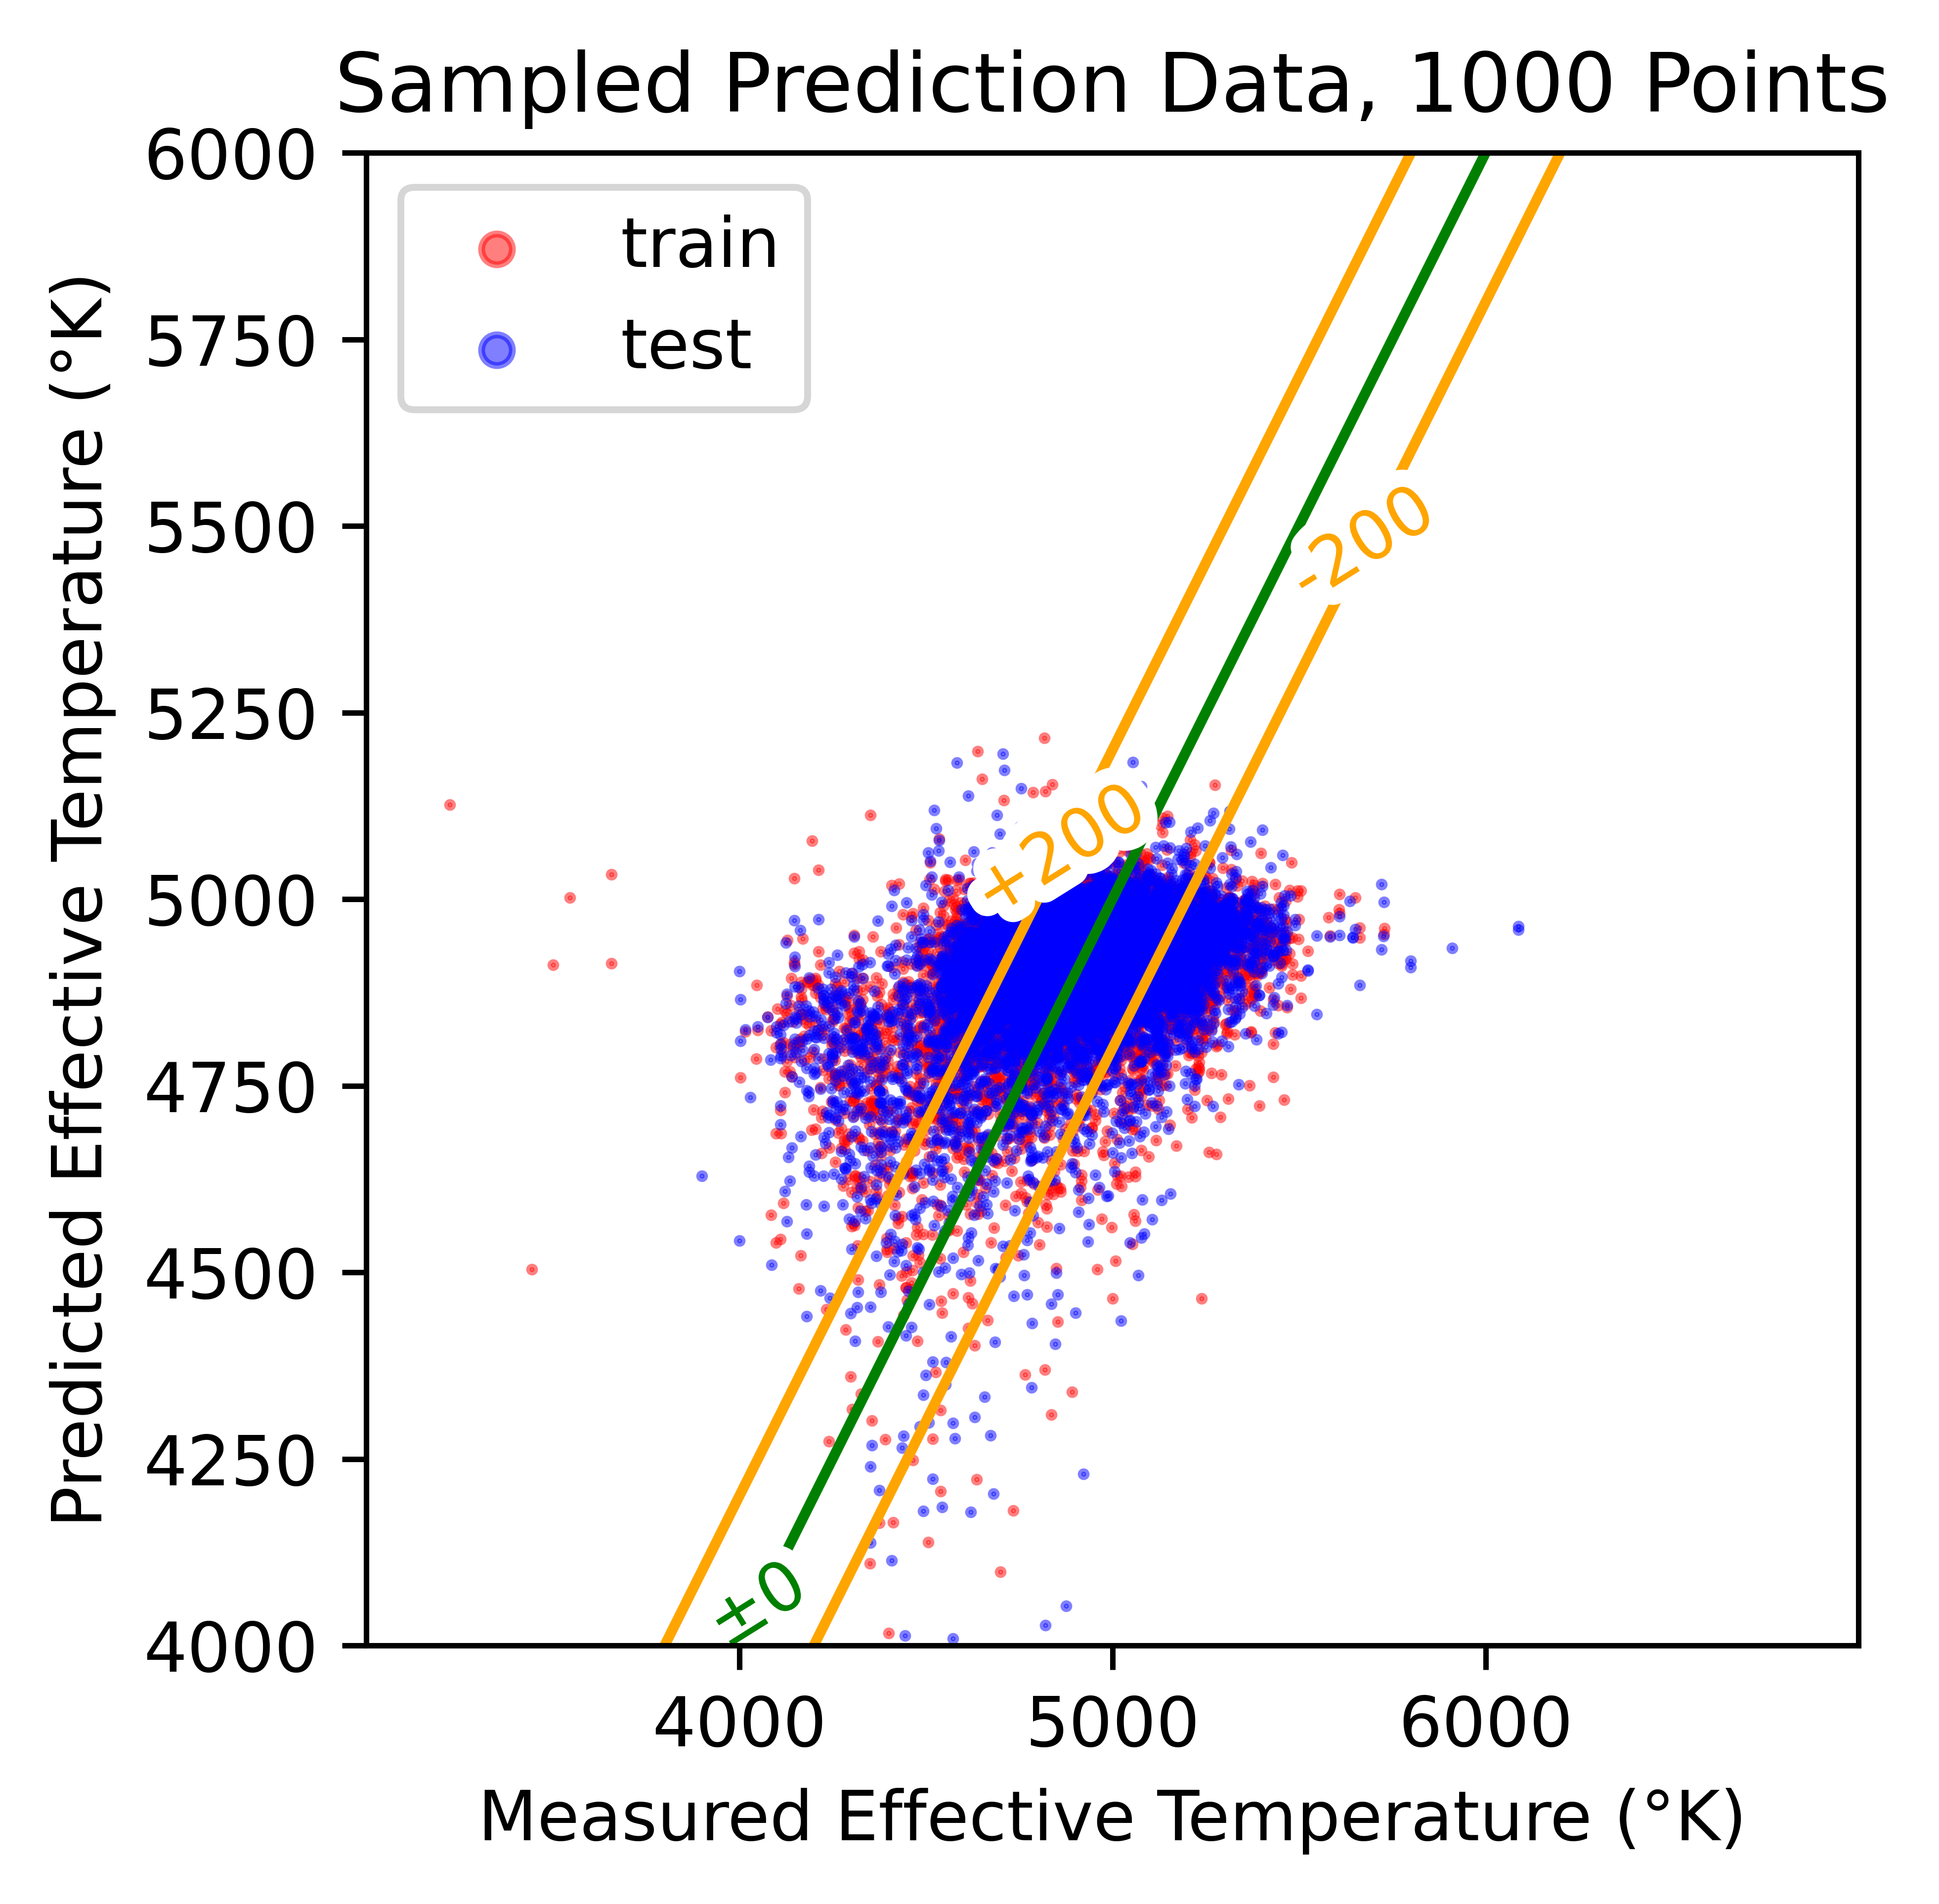

In [112]:
plt.rcParams['figure.dpi'] = 1000
# plt.figure(figsize = (6.4,4.8))
plt.scatter(train_y[:10000],pred_train_y[:10000], c='red', alpha=0.5,s=0.5)
plt.scatter(test_y[:10000],pred_test_y[:10000], c='blue', alpha=0.5,s=0.5)
# plt.hist2d(train_y,pred_train_y,bins=[100,100],cmin=20)
# plt.hist2d(test_y,pred_test_y,bins=[100,100],cmin=20,cmap=plt.cm.BuPu)


# plt.scatter(rand_y,pred_rand_y, c='orange', alpha=0.5,s=0.1)

bot = 4000
top = 6000
# bot = 2
# top = 4

linex = np.linspace(bot-500, top+500)
liney = linex
lineytop = linex*1.06
lineybot = linex*0.94
lineytop2 = linex+200
lineybot2 = linex-200
# Create the plot
plt.plot(linex, liney,c="green",label="±0")
# plt.plot(linex, lineytop,c="red",label="+6%")
# plt.plot(linex, lineybot,c="red",label="-6%")
plt.plot(linex, lineytop2,c="orange",label="+200")
plt.plot(linex, lineybot2,c="orange",label="-200")
labelLines(plt.gca().get_lines(), zorder=2.5)


plt.xlim(bot-999, top+999)
plt.ylim(bot, top)
plt.gca().set_aspect(2, adjustable='box')
plt.title('Sampled Prediction Data, 1000 Points')
plt.ylabel('Predicted Effective Temperature (°K)')
plt.xlabel('Measured Effective Temperature (°K)')
lgnd = plt.legend(['train', 'test'], loc='upper left')
lgnd.legendHandles[0]._sizes = [20]
lgnd.legendHandles[1]._sizes = [20]
plt.savefig('/Users/michaelsong/Documents/GitHub/starzam/Results/s3.png')
plt.show()


In [102]:
def normalize1D(data):
    return np.divide(np.nan_to_num(data,np.nanmean(data)),np.nanmax(data))

In [103]:
mse = mean_squared_error(normalize1D(test_y),normalize1D(pred_test_y),squared=False)
mae = mean_absolute_error(normalize1D(test_y),normalize1D(pred_test_y))
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
0.09558146 0.089299604


In [104]:
mse = mean_squared_error(test_y,pred_test_y,squared=False)
mae = mean_absolute_error(test_y,pred_test_y)
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
210.80678 163.51587


In [105]:
mse = mean_squared_error(normalize1D(train_y),normalize1D(pred_train_y),squared=False)
mae = mean_absolute_error(normalize1D(train_y),normalize1D(pred_train_y))
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
0.13512915 0.13105673


In [106]:
mse = mean_squared_error(train_y,pred_train_y,squared=False)
mae = mean_absolute_error(train_y,pred_train_y)
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
209.8654 163.188


In [107]:
mse = mean_squared_error(normalize1D(rand_y),normalize1D(pred_rand_y),squared=False)
mae = mean_absolute_error(normalize1D(rand_y),normalize1D(pred_rand_y))
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
0.05152043385412607 0.04271275307698405


In [108]:
mse = mean_squared_error(rand_y,pred_rand_y,squared=False)
mae = mean_absolute_error(rand_y,pred_rand_y)
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
219.06965009701563 168.67149274401567


In [109]:
errormargin = 0.03
test_count = 0
for i in range(len(normalize1D(test_y))):
    if test_y[i]*(1-errormargin) <= pred_train_y[i] <= test_y[i]*(1+errormargin):
        test_count+= 1
train_count = 0
for i in range(len(normalize1D(train_y))):
    if train_y[i]*(1-errormargin) <= pred_train_y[i] <= train_y[i]*(1+errormargin):
        train_count+= 1
rand_count = 0
for i in range(len(normalize1D(rand_y))):
    if rand_y[i]*(1-errormargin) <= pred_rand_y[i] <= rand_y[i]*(1+errormargin):
        rand_count+= 1

print(test_count,len(test_y),train_count,len(train_y),rand_count,len(rand_y))
print(test_count/len(test_y),train_count/len(train_y),rand_count/len(rand_y))

20722 42900 92250 171599 113197 215222
0.48303030303030303 0.5375905453994487 0.5259545957197684


In [110]:
errormargin = 200
test_count = 0
for i in range(len(normalize1D(test_y))):
    if test_y[i]-errormargin <= pred_train_y[i] <= test_y[i]+errormargin:
        test_count+= 1
train_count = 0
for i in range(len(normalize1D(train_y))):
    if train_y[i]-errormargin <= pred_train_y[i] <= train_y[i]+errormargin:
        train_count+= 1
rand_count = 0
for i in range(len(normalize1D(rand_y))):
    if rand_y[i]-errormargin <= pred_rand_y[i] <= rand_y[i]+errormargin:
        rand_count+= 1

print(test_count,len(test_y),train_count,len(train_y),rand_count,len(rand_y))
print(test_count/len(test_y),train_count/len(train_y),rand_count/len(rand_y))

26583 42900 117667 171599 144816 215222
0.6196503496503496 0.6857091241790453 0.6728680153515905


# Testing

In [36]:
float(model.predict(all_data[i][3:121].reshape(-1,118)))

IndexError: index 215221 is out of bounds for axis 0 with size 214499

In [ ]:
def testpred_avg(all_data):
    all_y = []
    pred_all_y = []
    kic = all_data[0][0]
    kic_y = []
    for i in range(len(all_data[:10000])):
        kic_y.append(float(model.predict(all_data[i][3:121].reshape(-1,118))))
        if(all_data[i][0]!=kic):
            kic = all_data[i][0]
            all_y.append(all_data[i][1])
            pred_all_y.append(sum(kic_y)/len(kic_y))
            kic_y = []

    return all_y,pred_all_y
all_y,pred_all_y = testpred_avg(all_data)

In [311]:
plt.scatter(all_y,pred_all_y, c='red', alpha=0.5,s=2)

linex = np.linspace(4000, 6000)
liney = linex
lineytop = linex+200
lineybot = linex-200
lineytop2 = linex*1.03
lineybot2 = linex*0.97
# Create the plot
plt.plot(linex, liney,c="green")
plt.plot(linex, lineytop,c="red")
plt.plot(linex, lineybot,c="red")
plt.plot(linex, lineytop2,c="purple")
plt.plot(linex, lineybot2,c="purple")


plt.xlim(4000, 6000)
plt.ylim(4000, 6000)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('/Users/michaelsong/Documents/GitHub/starzam/Results/4.2.png')
plt.show()


NameError: name 'all_y' is not defined

In [52]:
mse = np.sqrt(mean_squared_error(normalize1D(all_y),normalize1D(pred_all_y)))
mae = mean_absolute_error(normalize1D(all_y),normalize1D(pred_all_y))
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
0.1390003082706839 0.13103416677353238
